In [20]:
import numpy as np
import pandas as pd
import copy, random, warnings
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from spectralnet import SpectralNet
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import time

from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

import os
import matplotlib.pyplot as plt
#import holidays
import json
#import seaborn as sns
import pandas as pd
import numpy as np
import random
from collections import defaultdict

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# from blitz.modules import BayesianLSTM
# from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque
from collections import Counter

In [3]:
def calculate_metrics(model, X_train_scaled, y_train, X_test_scaled, y_test, y_scaler):
    # Predictions on training data
    train_pred = model.predict(X_train_scaled)
    train_pred_inverse = y_scaler.inverse_transform(train_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics for training data
    train_mape = np.mean(np.abs((y_train - train_pred_inverse) / y_train)) * 100
    train_mse = mean_squared_error(y_train, train_pred_inverse)
    train_rmse = np.sqrt(train_mse)
    train_mae = mean_absolute_error(y_train, train_pred_inverse)
    
    # Predictions on testing data
    test_pred = model.predict(X_test_scaled)
    test_pred_inverse = y_scaler.inverse_transform(test_pred.reshape(-1, 1)).flatten()
    
    # Calculate metrics for testing data
    test_mape = np.mean(np.abs((y_test - test_pred_inverse) / y_test)) * 100
    test_mse = mean_squared_error(y_test, test_pred_inverse)
    test_rmse = np.sqrt(test_mse)
    test_mae = mean_absolute_error(y_test, test_pred_inverse)
    
    # Print results
    print(f"Train MAPE: {train_mape:.2f}")
    print(f"Train MAE:  {train_mae:.2f}")
    print(f"Train MSE:  {train_mse:.2f}")
    print(f"Train RMSE: {train_rmse:.2f}")
    print(f"Test MAPE:  {test_mape:.2f}")
    print(f"Test MAE:   {test_mae:.2f}")
    print(f"Test MSE:   {test_mse:.2f}")
    print(f"Test RMSE:  {test_rmse:.2f}")
    
    # Return results in a dictionary
    return {
        'train_mape': train_mape,
        'train_mae': train_mae,
        'train_mse': train_mse,
        'train_rmse': train_rmse,
        'test_mape': test_mape,
        'test_mae': test_mae,
        'test_mse': test_mse,
        'test_rmse': test_rmse
    }

In [4]:
train_data = pd.read_csv("train_2021.xls")
test_data = pd.read_csv("test_2022.xls")

In [5]:
X_cols = [
    'hour', 'minute', 'quarter', 'holiday', 'temp',
    'power_lag_1_day', 'power_lag_2_day',
    'power_lag_3_day', 'power_lag_4_day'
]

X_train, y_train = train_data[X_cols], train_data['total_power']
X_test,  y_test  = test_data [X_cols], test_data ['total_power']

X_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X_train_s = X_scaler.fit_transform(X_train)
X_test_s  = X_scaler.transform(X_test)

y_train_s = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_test_s  = y_scaler.transform(y_test .values.reshape(-1, 1)).ravel()


In [6]:
start_time = time.time()
# Ridge model (no GridSearch)
ridge = Ridge(alpha=0.7).fit(X_train_s, y_train_s)

print(f"LR time: {time.time()-start_time}")

start_time = time.time()

# Grid Search for Gradient Boosting Regressor
gbr_grid = {
    'n_estimators': [75, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 4]
}
gbr_search = GridSearchCV(
    GradientBoostingRegressor(),
    gbr_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
)
gbr_search.fit(X_train_s, y_train_s)
gbr_best_params = gbr_search.best_params_
print(f"GBR time: {time.time()-start_time}")


start_time = time.time()

# Grid Search for LightGBM
lgbm_grid = {
    'n_estimators': [50, 75],
    'learning_rate': [0.01, 0.1],
    'max_depth': [-1, 10, 15],
    # 'num_leaves': [20, 50],
    #'min_child_samples': [10, 20]
}
# lgbm_search = GridSearchCV(
#     LGBMRegressor(verbosity=-1),
#     lgbm_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1
# )
# lgbm_search.fit(X_train_s, y_train_s)
# lgbm_best_params = lgbm_search.best_params_
# print(f"LGBM time: {time.time()-start_time}")



# Perform grid search
lgbm_grid_search = GridSearchCV(
    LGBMRegressor(verbosity=-1),
    lgbm_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=0
)
start =  time.time()
# Fit the model
lgbm_grid_search.fit(X_train_s, y_train_s)

# Best estimator
lgbm = lgbm_grid_search.best_estimator_
print("Training Time:", time.time() - start)

LR time: 0.0022563934326171875
GBR time: 15.587841272354126


/scratch/user/u.rd143338/.conda/envs/bayesian_PI/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Training Time: 35.807960987091064


In [7]:
def inv_pred(model):
    return y_scaler.inverse_transform(model.predict(X_train_s).reshape(-1,1)).ravel(), \
           y_scaler.inverse_transform(model.predict(X_test_s ).reshape(-1,1)).ravel()
n_train_days = len(y_train) // 96           # 96 × 15-min = 1 day
n_test_days  = len(y_test)  // 96

ridge = Ridge(alpha=0.7).fit(X_train_s, y_train_s)
ridge_train_pred, ridge_test_pred = inv_pred(ridge)
ridge_resid = y_train.values - ridge_train_pred
ridge_res_tensor = ridge_resid.reshape(n_train_days, 24, 4)

gbr = GradientBoostingRegressor(**gbr_best_params).fit(X_train_s, y_train_s)
gbr_train_pred , gbr_test_pred  = inv_pred(gbr)
gbr_resid   = y_train.values - gbr_train_pred
gbr_res_tensor   = gbr_resid.reshape(n_train_days, 24, 4)

#lgbm = LGBMRegressor(**lgbm_best_params,  verbosity=-1).fit(X_train_s, y_train_s)
lgbm_train_pred, lgbm_test_pred = inv_pred(lgbm)
lgbm_resid  = y_train.values - lgbm_train_pred
lgbm_res_tensor  = lgbm_resid.reshape(n_train_days, 24, 4)


In [8]:
residual_pool = {
    'ridge': ridge_res_tensor,
    'gbr'  : gbr_res_tensor,
    'lgbm' : lgbm_res_tensor
}

daily_pred = {
    'ridge': ridge_test_pred.reshape(n_test_days, 96),
    'gbr'  : gbr_test_pred .reshape(n_test_days, 96),
    'lgbm' : lgbm_test_pred.reshape(n_test_days, 96)
}

In [22]:
resacfplot = residual_pool['gbr'].flatten()

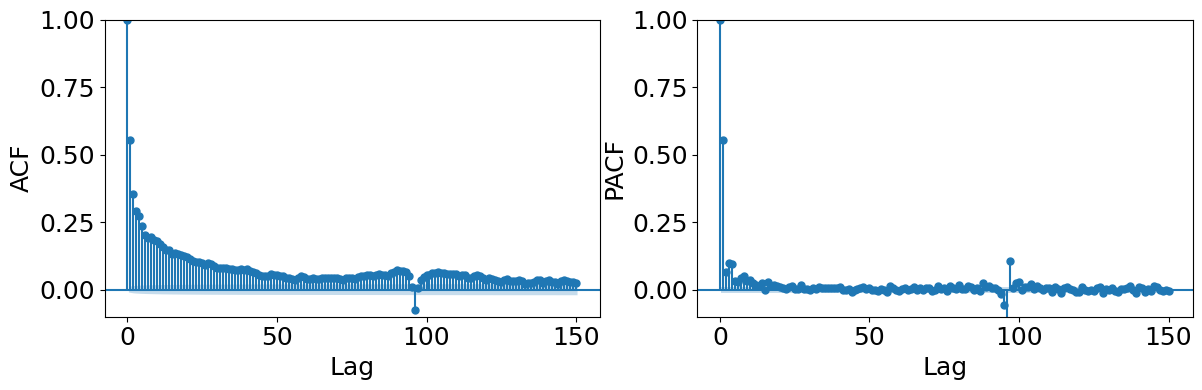

In [23]:
# Create the subplots with reduced figure size
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot ACF and PACF with appropriate font sizes
plot_acf(resacfplot, lags=150, ax=ax[0])
plot_pacf(resacfplot, lags=150, ax=ax[1], method='ols')
# Remove automatically generated titles
ax[0].set_title("")  
ax[1].set_title("")
# Set y-axis limits to remove excessive negative space
ax[0].set_ylim(-0.1, 1.0)  # Adjust based on actual ACF values
ax[1].set_ylim(-0.1, 1.0)  # Adjust based on actual PACF values

# Set axis labels with font size 18
ax[0].set_ylabel("ACF", fontsize=18)
ax[1].set_ylabel("PACF", fontsize=18)

# Keep "Lag" as the x-axis label for both plots
for a in ax:
    a.set_xlabel("Lag", fontsize=18)
    a.tick_params(axis='both', which='both', labelsize=18)

# Adjust layout
plt.tight_layout()

# Save the figure in high resolution
plt.savefig("res_acf_pacf_plotiise.png", dpi=700, bbox_inches='tight')  # High resolution for publication

# Show the plot
plt.show()

In [24]:
def winkler_score_and_coverage(df, obs, CIs):
    out = {}
    obs = np.asarray(obs)
    for ci in CIs:
        ci /= 100
        lq, uq = df.quantile((1-ci)/2), df.quantile(1-(1-ci)/2)
        alpha_inv = 1/(1-ci)

        lower = obs <= lq
        middle = (obs > lq) & (obs < uq)
        upper = obs >= uq

        w = np.zeros_like(obs, dtype=float)
        w[lower]  = (uq[lower]-lq[lower]) + 2*alpha_inv*(lq[lower]-obs[lower])
        w[middle] = (uq[middle]-lq[middle])
        w[upper]  = (uq[upper]-lq[upper]) + 2*alpha_inv*(obs[upper]-uq[upper])

        out[int(ci*100)] = {
            'winkler_scores': w.mean(),
            'coverage_probability': middle.mean()
        }
    return out

In [25]:
def bootstrap_blocks(res_tensor, point_pred, N, rng):
    """Return DataFrame shape (N, n_test_days*96)."""
    src_days = res_tensor.shape[0]
    blocks = []
    for _ in range(N):
        idx = rng.integers(0, src_days, size=point_pred.shape[0])
        boot = res_tensor[idx].reshape(point_pred.shape) + point_pred
        blocks.append(boot)
    return pd.DataFrame(np.vstack(blocks).reshape(N, -1))

In [26]:
N = 1000
seed = 11
rng = np.random.default_rng(seed)
CIs = [85, 90, 95, 99, 99.9]

for tag in ['ridge', 'gbr', 'lgbm']:
    start_time = time.time()
    sim_df = bootstrap_blocks(residual_pool[tag], daily_pred[tag], N, rng)
    res_df = pd.DataFrame(winkler_score_and_coverage(sim_df, y_test.values, CIs)).T
    print(f"time for {tag} is {time.time()-start_time}")
    print(res_df)
    res_df.to_csv(f"{tag}_res_noclust.csv", index=False)

time for ridge is 1.177152395248413
    winkler_scores  coverage_probability
85        8.676167              0.738426
90        9.698894              0.806019
95       11.492715              0.886227
99       41.881450              0.981134
time for gbr is 1.1761772632598877
    winkler_scores  coverage_probability
85        7.704590              0.708796
90        8.699183              0.780556
95       10.440155              0.859259
99       52.423161              0.973958
time for lgbm is 1.1701102256774902
    winkler_scores  coverage_probability
85        7.735127              0.718519
90        8.722133              0.783681
95       10.459339              0.866319
99       48.800479              0.976157
